# Animal detection

### Introduction

### Imports and settings

In [1]:
# Standard Python libraries:
import datetime
import operator
import os
import random
import shutil
import sys
from typing import List, Tuple
import warnings

# Data processing and modeling:
from keras.callbacks import TensorBoard
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization
from keras.models import Sequential
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.regularizers import l2
from keras.utils import to_categorical
import numpy as np
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

# Data visualization:
from IPython import display
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# Settings:
warnings.filterwarnings("ignore")
np.set_printoptions(threshold=sys.maxsize)

### Data exploration

To get a feel for the data we are working with, let us inspect two random images: one from the training set and one from the test set:

In [2]:
data_dir = "data/"
# example_path = data_dir + "train/Butterfly/0ac0ebf6b74941a5.jpg"
# example_img = load_img(example_path)
# print("Random train image:\n")
# print("Format:\t", example_img.format)
# print("Mode:\t", example_img.mode)
# print("Size:\t", example_img.size)
# display.Image(example_path)

In [3]:
# example_path = data_dir + "test/Kangaroo/1df62fe536aae753.jpg"
# example_img = load_img(example_path)
# print("Random test image:\n")
# print("Format:\t", example_img.format)
# print("Mode:\t", example_img.mode)
# print("Size:\t", example_img.size)
# display.Image(example_path)

Both images have three color channels and they have almost the same resolution. For our CNN we need a fixed resolution, which might lead to rescaling or dropping of certain images. In the following we will inspect all image modes and resolutions to map the characteristics of our datasets. To this end, we will define a function that can obtain the full paths of all images in a given folder:

In [4]:
def get_files(
    dir_path: str, 
    extensions: Tuple[str] = (".jpg", ".jpeg", ".png"),
) -> List[str]:
    """Obtain all files in the directory tree of the given folder.

    Args:
        dir_path: The path to the directory.
        extensions: Optional argument that can be used to specify 
            desired extensions. By default only images are listed.

    Returns:
        List of full paths to all files that are contained in
        the input directory, including subdirectories.
    """

    list_of_items = os.listdir(dir_path)
    all_files = []
    for item in list_of_items:
        full_path = os.path.join(dir_path, item).strip()
        if os.path.isdir(full_path):
            all_files = all_files + get_files(full_path)
        else:
            if full_path.endswith(extensions):
                all_files.append(full_path)

    return all_files

In [5]:
img_paths = get_files(data_dir + "train")
data_info = {"Formats": {}, "Modes": {}, "Sizes": {}, "Resolutions": {}}
failed_imgs = []
successes = 0

# Determine characterics for each image:
for img_path in img_paths:
    try:
        img = load_img(img_path)      
        ext = img.format
        if ext not in data_info["Formats"]:
            data_info["Formats"][ext] = 1
        else:
            data_info["Formats"][ext] += 1
            
        mode = img.mode
        if mode not in data_info["Modes"]:
            data_info["Modes"][mode] = 1
        else:
            data_info["Modes"][mode] += 1
            
        size = img.size
        if size not in data_info["Sizes"]:
            data_info["Sizes"][size] = 1
        else:
            data_info["Sizes"][size] += 1
            
        resolution = size[0] * size[1]
        if resolution not in data_info["Resolutions"]:
            data_info["Resolutions"][resolution] = 1
        else:
            data_info["Resolutions"][resolution] += 1
        
        successes += 1
    except:
        failed_imgs.append(img_path)

# Sort dictionaries by values:
data_info["Formats"] = sorted(data_info["Formats"].items(), key=operator.itemgetter(1), reverse=True)
data_info["Modes"] = sorted(data_info["Modes"].items(), key=operator.itemgetter(1), reverse=True)
data_info["Sizes"] = sorted(data_info["Sizes"].items(), key=operator.itemgetter(1), reverse=True)
data_info["Resolutions"] = sorted(data_info["Resolutions"].items(), key=operator.itemgetter(0), reverse=True)

print(f"There are {len(failed_imgs)} corrupt images in the dataset. Based on the remaining {successes} images, the dataset characteristics are as follows:")
print("\nFormats:\t", data_info["Formats"])
print("\nModes:\t\t", data_info["Modes"])
print("\nSizes:\t\t", data_info["Sizes"])
print("\nResolutions:\t", data_info["Resolutions"])

There are 0 corrupt images in the dataset. Based on the remaining 1437 images, the dataset characteristics are as follows:

Formats:	 [('JPEG', 1413), (None, 24)]

Modes:		 [('RGB', 1437)]

Sizes:		 [((1024, 768), 326), ((1024, 683), 240), ((683, 1024), 63), ((768, 1024), 55), ((1024, 685), 52), ((1024, 682), 49), ((1024, 681), 39), ((1024, 1024), 37), ((1024, 680), 33), ((1024, 576), 29), ((1024, 678), 20), ((1024, 640), 15), ((1024, 686), 11), ((1024, 684), 10), ((1024, 819), 8), ((682, 1024), 8), ((685, 1024), 8), ((681, 1024), 7), ((1024, 575), 6), ((1024, 737), 6), ((680, 1024), 5), ((1024, 679), 5), ((1024, 771), 5), ((1024, 668), 5), ((1024, 731), 5), ((1024, 766), 4), ((1024, 687), 4), ((768, 768), 4), ((1024, 716), 3), ((678, 1024), 3), ((1024, 620), 3), ((1024, 773), 3), ((1024, 767), 3), ((1024, 732), 3), ((819, 1024), 3), ((1024, 769), 3), ((687, 1024), 3), ((732, 1024), 3), ((1024, 725), 3), ((1024, 667), 3), ((1024, 692), 3), ((1024, 671), 3), ((912, 1024), 3), ((1024, 76

All images in the dataset are of the RGB type. The sizes, however, vary considerably. The most common number of pixels for the long edge is 1024. The smallest resolutions found in the dataset are ~300,000 pixels.

### Preprocessing

Before we can train a model, we need to put our data into the right form. Our CNN will need a fixed input size. In other words, all input images require the same resolution. It is convenient to work with a square resolution so that horizontal and vertical images are treated on an equal footing. To compensate for the original non-squareness we can pad the images with zeros (i.e. add black pixels). Given the smallest resolutions found in the dataset, a good resolution to work with would be 512 x 512 = 262,144 pixels.

In [6]:
# Resize images to target dimensions with padding:
target_height = 512
target_width = 512
train_dir = data_dir + "train"
img_paths = get_files(train_dir)
img_list = []
label_list = []
for img_path in img_paths:
    img = load_img(img_path)
    img_arr = img_to_array(img)
    img_pad_arr = tf.image.resize_with_pad(
        img_arr,
        target_height,
        target_width,
    )
    img_pad_arr /= 255  # Map pixel values to [0,1].
    img_list.append(img_pad_arr)
    label = os.path.basename(os.path.dirname(img_path))
    label_list.append(label)

# Create feature and label tensors for training data:    
train_features = np.stack(img_list, axis=0)
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(label_list)
train_labels = to_categorical(train_labels)

print("Dimensions of tensor for input features:\t", train_features.shape)
print("Dimensions of tensor for output labels:\t\t", train_labels.shape)



# Resize images to target dimensions with padding:
val_dir = data_dir + "test"
img_paths = get_files(val_dir)
img_list = []
label_list = []
for img_path in img_paths:
    img = load_img(img_path)
    img_arr = img_to_array(img)
    img_pad_arr = tf.image.resize_with_pad(
        img_arr,
        target_height,
        target_width,
    )
    img_pad_arr /= 255  # Map pixel values to [0,1].
    img_list.append(img_pad_arr)
    label = os.path.basename(os.path.dirname(img_path))
    label_list.append(label)

# Create feature and label tensors for training data:    
val_features = np.stack(img_list, axis=0)
label_encoder = LabelEncoder()
val_labels = label_encoder.fit_transform(label_list)
val_labels = to_categorical(val_labels)

print("Dimensions of tensor for validation features:\t", val_features.shape)
print("Dimensions of tensor for validation labels:\t\t", val_labels.shape)

Dimensions of tensor for input features:	 (1437, 512, 512, 3)
Dimensions of tensor for output labels:		 (1437, 4)
Dimensions of tensor for validation features:	 (407, 512, 512, 3)
Dimensions of tensor for validation labels:		 (407, 4)


It is good practice to check whether the resized and padded images are what we expect them to be. So let us look at a few examples:

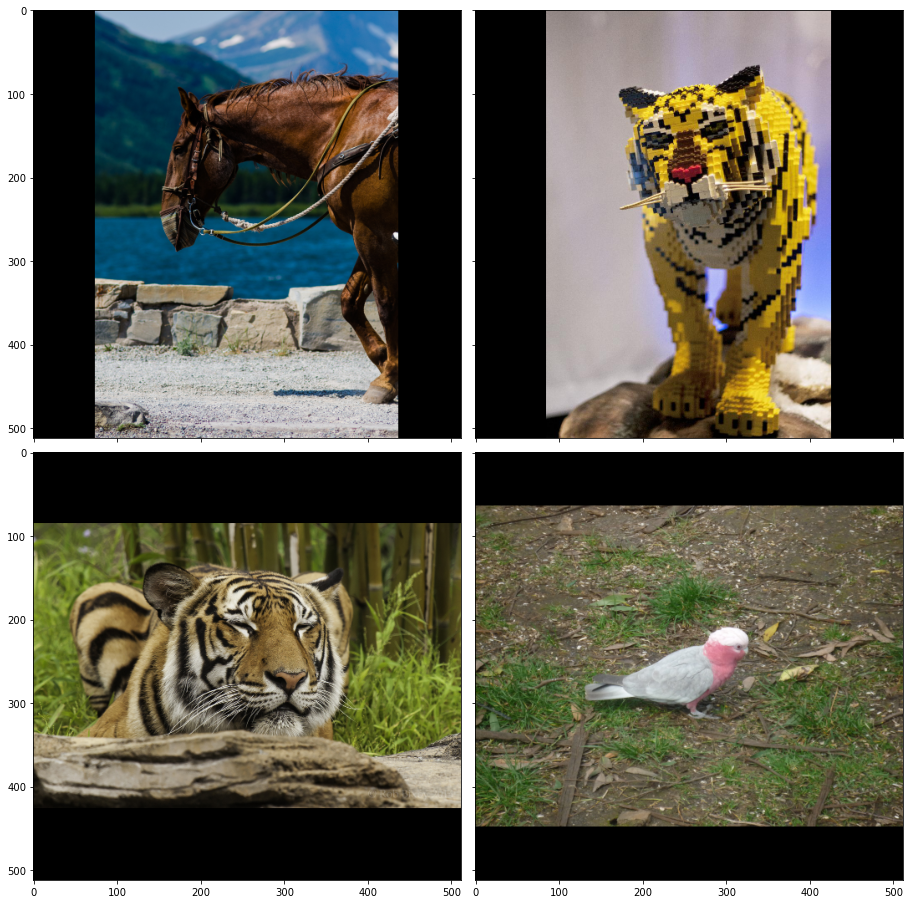

In [7]:
# Randomly select 4 images:
img_arrays = []
for i in range(4):
    random.seed(i)
    rand_int = random.randrange(train_features.shape[0])
    example_array = train_features[rand_int, :, :, :]
    img_arrays.append(example_array)

# Create image grid:
fig = plt.figure(figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 2), axes_pad=0.2)
for ax, im in zip(grid, img_arrays):
    ax.imshow(im)
plt.show()

### Model building

In this section we build and train a CNN using Keras.

The model architecture is given by:

In [8]:
num_classes = train_labels.shape[1]

model = Sequential(name="CNN_for_animal_classification")
model.add(Conv2D(64, kernel_size=(5, 5), padding="same", activation="relu", input_shape=(512, 512, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(4, 4), padding="same"))
model.add(Dropout(0.1, seed=0))
model.add(Conv2D(32, kernel_size=(5, 5), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(4, 4), padding="same"))
model.add(Conv2D(16, kernel_size=(5, 5), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(4, 4), padding="same"))
model.add(Flatten())
model.add(Dense(100, activation="relu", kernel_regularizer=l2(l2=0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5, seed=0))
model.add(Dense(num_classes, activation="softmax"))

model.summary()

Model: "CNN_for_animal_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 512, 512, 64)      4864      
_________________________________________________________________
batch_normalization (BatchNo (None, 512, 512, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      51232     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3

Next, we can set the loss function, the optimization algorithm, and the proper metric:

In [9]:
model.compile(
    optimizer="adam", 
    loss="categorical_crossentropy", 
    metrics=['accuracy'],
)

The training and validation sets can be defined using the ImageDataGenerator. Since we only want to apply data augmentation to the training set, we need to set the random seeds in both generators equal to each other.

In [10]:
# Set parameters:
val_frac = 0.2
batch_size = 8

# Specify training set, including data augmentation:
train_datagen = ImageDataGenerator(
    rotation_range=6,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    fill_mode="constant",
    cval=0,
    horizontal_flip=True,
#     validation_split=val_frac,
)
train_generator = train_datagen.flow(
    train_features,
    y=train_labels,
    batch_size=batch_size,
#     seed=0,
#     subset="training",
)

# Specify validation set:
val_datagen = ImageDataGenerator() # ImageDataGenerator(validation_split=val_frac)
val_generator = val_datagen.flow(
    val_features, # train_features,
    y=val_labels, # y=train_labels,
    batch_size=batch_size,
#     seed=0,
#     subset="validation",
)

During training, we will visualize the loss function using TensorBoard. To view current progress, use the refresh button.

In [11]:
# Define TensorBoard callback:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
if os.path.isdir("logs"):
    shutil.rmtree("logs")
log_dir = os.path.join("logs", current_time)
tensorboard_callback = TensorBoard(log_dir, histogram_freq=1)

# Visualize loss function:
%load_ext tensorboard
%tensorboard --logdir logs

Finally we can train our CNN. The model weights are saved to an h5 file.

In [ ]:
# Train model:
epochs = 5
# model.fit_generator(
#     train_generator,
#     epochs=epochs,
#     validation_data=val_generator,
#     callbacks=[tensorboard_callback],
# 
model.fit(
    x=train_generator,
    epochs=epochs,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[tensorboard_callback],
)

# Save weights:
weights_path = "weights_" + current_time + ".h5"
model.save_weights(weights_path)

Epoch 1/5
 15/180 [=>............................] - ETA: 14:02 - loss: 3.5317 - accuracy: 0.3909

#### To do:

- Add pretrained weights.